# Predicting the Impact of News Articles on Cryptocurrency Prices using Sentiment Analysis

#### Strategy:
1. Predict Sentiment using RNNs. 
2. Show relationship between sentiment and price.
3. Create article scoring based on price prediction using sentiment and vectorized article text as features. 


### 1. Import and Preprocess Data

#### 1.1 Import and pre-process articles

Our data sources are Bitcoin price data and news articles related to Bitcoin

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from pandas import DataFrame
from datetime import datetime,tzinfo
from pytz import timezone
import time
import pytz
import csv


plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
articles = pd.read_csv("./data/Classified Articles.csv")


In [3]:
articles["timeStamp"] = pd.to_datetime(articles['date'] + ' ' + articles['time'])

articles = articles.set_index("timeStamp")

In [4]:
articles.head(1)

,Unnamed: 0,index,author,contents,description,publisher,source_url,title,date,time,label,c,marks
timeStamp,,,,,,,,,,,,,
2018-01-23,0,0,Stripe.com,complete payments platform engineered growth b...,"At Stripe, we’ve long been excited about the p...",Stripe.com,https://stripe.com/blog/ending-bitcoin-support,Ending Bitcoin Support,2018-01-23,00:00:00,0.0,"['complete', 'payments', 'platform', 'engineer...",0


In [5]:
len(articles)

40732

In [6]:
min(articles.index)

Timestamp('2018-01-23 00:00:00')

In [7]:
max(articles.index)

Timestamp('2018-03-27 23:46:45')

#### 1.1.1 Import and Pre-process hand-labeled sentiment 

Since our data does not have sentiment labels, we will use different strategies to come up with labels. One of them is hand-labeling the data by reading articles (roughly 250 articles). Those articles are imported.

In [8]:
data = pd.read_csv("./data/Articles Reading Assignment.csv")
data.head(1)

,Name,URL,Sentiment
0,Sudarshan,https://www.wykop.pl/link/4223359/blockchain-a...,0.0


In [9]:
data = data.dropna()

data["contents"] = ["" for i in range(len(data))]
data["title"] = ["" for i in range(len(data))]
data["date"] = ["" for i in range(len(data))]
data["time"] = ["" for i in range(len(data))]
data["marks"] = ["" for i in range(len(data))]


for i, row in data.iterrows():
    x = row["URL"]
    
    key_words = articles[articles["source_url"] == x][:1]["contents"].values[0]
    data.at[i, "contents"] = str(key_words)
    
    title = articles[articles["source_url"] == x][:1]["title"].values[0]
    data.at[i, "title"] = str(title)
    
    date = articles[articles["source_url"] == x][:1]["date"].values[0]
    data.at[i, "date"] = date
    
    time = articles[articles["source_url"] == x][:1]["time"].values[0]
    data.at[i, "time"] = time
    
    marks = articles[articles["source_url"] == x][:1]["marks"].values[0]
    data.at[i, "marks"] = marks
      
data.head(1)

,Name,URL,Sentiment,contents,title,date,time,marks
0,Sudarshan,https://www.wykop.pl/link/4223359/blockchain-a...,0.0,ciastka strona korzysta z plik w cookies w cel...,Blockchain & Bitcoin Conference Berlin on Apri...,2018-03-21,11:54:35,1


In [10]:
data["timeStamp"] = pd.to_datetime(data['date'] + ' ' + data['time'])

data = data.set_index("timeStamp")

In [11]:
data.head(1)

,Name,URL,Sentiment,contents,title,date,time,marks
timeStamp,,,,,,,,
2018-03-21 11:54:35,Sudarshan,https://www.wykop.pl/link/4223359/blockchain-a...,0.0,ciastka strona korzysta z plik w cookies w cel...,Blockchain & Bitcoin Conference Berlin on Apri...,2018-03-21,11:54:35,1


In [12]:
len(data.loc[data["Sentiment"] == data["marks"]])

83

In [13]:
len(data)

246

In [14]:
data["Sentiment"] = pd.to_numeric(data["Sentiment"])
data["marks"] = pd.to_numeric(data["marks"])

In [15]:
data.head(1)

,Name,URL,Sentiment,contents,title,date,time,marks
timeStamp,,,,,,,,
2018-03-21 11:54:35,Sudarshan,https://www.wykop.pl/link/4223359/blockchain-a...,0.0,ciastka strona korzysta z plik w cookies w cel...,Blockchain & Bitcoin Conference Berlin on Apri...,2018-03-21,11:54:35,1


#### 1.2 Import and pre-process Bitcoin price data 

We import Bitcoin data on a minute basis. 

In [16]:
# import data: bitcoin prices
btc = pd.read_csv("./data/coinbaseUSD_1-min_data_2014-12-01_to_2018-03-27.csv")

# preprocess bitcoin price data 
btc.Timestamp = pd.to_datetime(btc.Timestamp, unit='s')
btc.Timestamp = btc.Timestamp.dt.tz_localize('UTC')

btc['log_close'] = np.log(btc.Close) - np.log(btc.Close.shift(1))
btc['Date'] = pd.to_datetime(btc['Timestamp']).dt.date

min_periods = 43200 # 60minutes*24hours*30days 

price=btc['Close']
# Calculate the sd and volatility
mean=price.rolling(min_periods).mean()
sd=price.rolling(min_periods).std()
vol = price.rolling(min_periods).std() * np.sqrt(min_periods) 
btc['Average']=mean
btc['Volatility']=vol
btc['SD']=sd

price_log=btc['log_close']
# Calculate the sd and volatility
mean=price_log.rolling(min_periods).mean()
sd=price_log.rolling(min_periods).std()
vol = price_log.rolling(min_periods).std() * np.sqrt(min_periods) 
btc['Average_log']=mean
btc['Volatility_log']=vol
btc['SD_log']=sd

index_1 = btc[btc.Date == datetime.date(dt.datetime.strptime('01/23/18', '%x'))].index[0]
index_2 = btc[btc.Date == datetime.date(dt.datetime.strptime('03/27/18', '%x'))].index[0]
btc_1= btc.loc[index_1:index_2]

btc_1 = btc_1.set_index("Timestamp")


In [17]:
max(articles.index)

Timestamp('2018-03-27 23:46:45')

In [18]:
min(articles.index)

Timestamp('2018-01-23 00:00:00')

Plot data

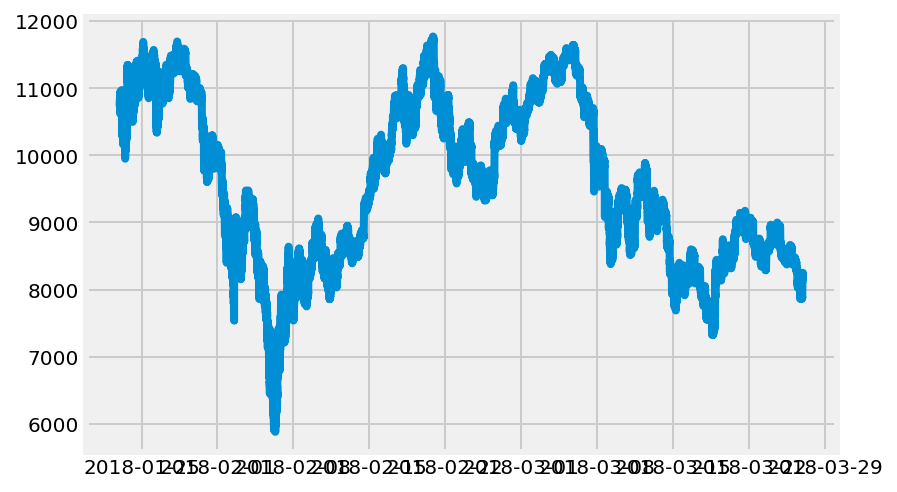

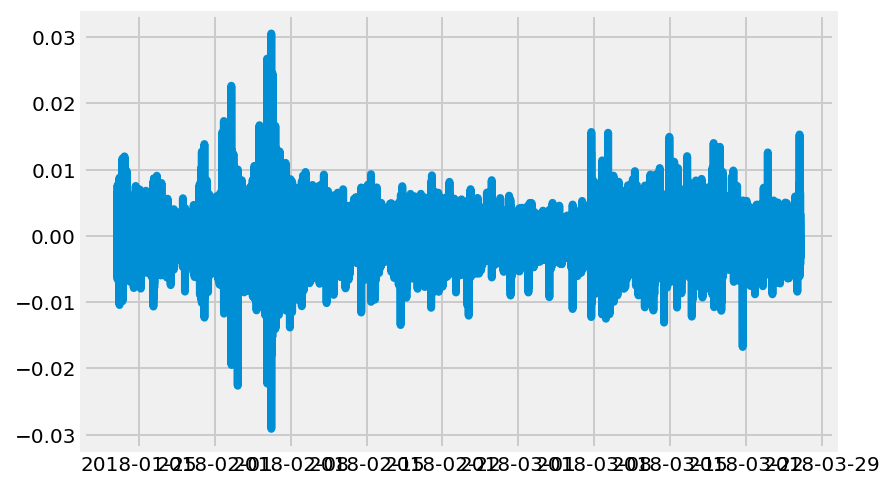

In [19]:
btc_close = btc_1['Close']
plt.plot(btc_close)
plt.show()


btc_log_close = btc_1['log_close']
plt.plot(btc_log_close)
plt.show()


The charts show our sample period. 

### 1.3 Create lags of Bitcoin price data

Since we are testing the impact of news on Bitcoin prices for different time lags, we need to create Bitcoin prices for diffrent time lags based on when a news article is published (e.g. if we have 1 day time lag, we are looking at the Bittcoin price 24 hours after a given article was published).
Caution: this code takes like 30 minutes to run. 

In [20]:
# create response add response with multiple lags in seconds
import datetime
import time

start = time.time()

response = pd.DataFrame()
benchmark_naive = pd.DataFrame()

# 1 minute, 5 minutes, 10 minutes, 30 minutes, 60 minutes, 12 hours, 1 day, 2 days, 4 days 
colnames = {"lag_1m":60,"lag_5m":300,"lag_10m":600,"lag_30m":1800,"lag_60m":3600,"lag_12h":43200,"lag_1d":86400,
            "lag_2d":172800,"lag_4d" : 345600}


train_time = pd.to_datetime(articles.index)

for colname in colnames:
    stock_return = []
    stock_return_naive = []
    lag = colnames[colname]
    
    for i in train_time:
        try:
            start_price = btc_1.Close.iloc[btc_1.index.get_loc(i,method = "nearest")]
            end_price = btc_1.Close.iloc[btc_1.index.get_loc((i+datetime.timedelta(0,lag)),method = "nearest")]
            stock_return.append(end_price/start_price-1)
            
            end_price_naive = btc_1.Close.iloc[btc_1.index.get_loc(i,method = "nearest")]
            start_price_naive = btc_1.Close.iloc[btc_1.index.get_loc((i-datetime.timedelta(0,lag)),method = "nearest")]
            stock_return_naive.append(end_price_naive/start_price_naive-1)
            
        except:
            stock_return.append(0)
            stock_return_naive.append(0)
            print("exception raised")

    response[colname] = stock_return
    benchmark_naive[colname] = stock_return_naive
    

print("time elapsed:",round((time.time()-start)/60,1),"minutes")

time elapsed: 23.6 minutes


In [21]:
response.head(1)

,lag_1m,lag_5m,lag_10m,lag_30m,lag_60m,lag_12h,lag_1d,lag_2d,lag_4d
0,-0.000255,-0.004628,0.003677,-0.006573,9.259276e-07,-0.066983,0.008283,0.048753,0.026566


In [22]:
benchmark_naive.head(1)

,lag_1m,lag_5m,lag_10m,lag_30m,lag_60m,lag_12h,lag_1d,lag_2d,lag_4d
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Sentiment Prediction

We predict the news articles' sentiment using different strategies and different models. 

### 2.1 Sentiment Prediction using RNNs

### 2.1.1 Sentiment Prediction using self-labeled Data

In [23]:
rnn_sentiment = pd.read_csv("./data/Articles with Sentiment.csv")
rnn_sentiment = rnn_sentiment["marks"]

In [24]:
rnn_sentiment.head(2)

0    1
1    1
Name: marks, dtype: int64

In [25]:
rnn_sentiment.shape

(40732,)

In [26]:
articles["rnn sentiment"] = list(rnn_sentiment)

In [27]:
articles.head()

,Unnamed: 0,index,author,contents,description,publisher,source_url,title,date,time,label,c,marks,rnn sentiment
timeStamp,,,,,,,,,,,,,,
2018-01-23 00:00:00,0,0,Stripe.com,complete payments platform engineered growth b...,"At Stripe, we’ve long been excited about the p...",Stripe.com,https://stripe.com/blog/ending-bitcoin-support,Ending Bitcoin Support,2018-01-23,00:00:00,0.0,"['complete', 'payments', 'platform', 'engineer...",0,1
2018-03-13 07:39:30,31650,31650,fisco,bitcoin news price information analysis week s...,"In the week starting Monday, March 5, some top...",Newsbtc.com,https://www.newsbtc.com/2018/03/13/services-br...,Services Bridging Cryptocurrencies and Investo...,2018-03-13,07:39:30,0.0,"['bitcoin', 'news', 'price', 'information', 'a...",0,1
2018-03-13 07:39:49,31651,31651,Apple,category video tutorial,Blockchain EOS - Discover How To Get & Send Et...,Gfxbing.com,http://gfxbing.com/video-tutorial/845272-block...,Blockchain EOS - Discover How To Get & Send Et...,2018-03-13,07:39:49,0.0,"['category', 'video', 'tutorial']",0,1
2018-03-13 07:44:37,31652,31652,Steven Hay,last updated march th initial coin offerings i...,The post What are ERC-20 Tokens? A Beginner’s ...,99bitcoins.com,https://99bitcoins.com/what-are-erc-20-tokens/,What are ERC-20 Tokens? A Beginner’s Explanation,2018-03-13,07:44:37,0.0,"['last', 'updated', 'march', 'th', 'initial', ...",0,1
2018-03-13 07:46:06,31653,31653,e27.co/elena.prokopets,future startups check tea talk week discussion...,"Blockchain can resolve a lot issues, for consu...",E27.co,https://e27.co/4-ways-blockchain-revolutionisi...,4 ways blockchain is revolutionising the trave...,2018-03-13,07:46:06,0.0,"['future', 'startups', 'check', 'tea', 'talk',...",0,1


### 2.2 Sentiment Prediction using decison-tree based models (random forest, gradient boosting)

In [28]:
data.head(1)

,Name,URL,Sentiment,contents,title,date,time,marks
timeStamp,,,,,,,,
2018-03-21 11:54:35,Sudarshan,https://www.wykop.pl/link/4223359/blockchain-a...,0.0,ciastka strona korzysta z plik w cookies w cel...,Blockchain & Bitcoin Conference Berlin on Apri...,2018-03-21,11:54:35,1


In [29]:
len(data)

246

#### 2.2.1 NLP 

We creaet a simple class that contains different NLP pre-processing methods. 

In [30]:
# create class which handles NLP tokenization, stemming/lemmatizing and tranformation to vector 
class nlp_validation_sets:
    
    def __init__(self,fold,validation,train_data,max_features=10,method_nlp = "stem",ngram = 1):
        self.fold = fold
        self.validation = validation
        self.max_features = max_features 
        self.method_nlp = method_nlp
        self.ngram = ngram
        self.train_data = train_data
        
        self.stemmed_word_list = []
        self.tokenized_word_list = []
        self.stemmed_word_list_only_bad = []
        self.tokenized_word_list_only_bad = []
        self.stemmed_word_list_val = []
        self.tokenized_word_list_val = []
        self.stemmed_word_list_train = []
        self.tokenized_word_list_train = []
    
    def choose_w2v(self,method = "tfidf"):
        from sklearn.feature_extraction.text import CountVectorizer
        from sklearn.feature_extraction.text import TfidfVectorizer
        
        if method == "tfidf":
            self.tfidf = TfidfVectorizer(max_features = self.max_features,ngram_range =(1,self.ngram),
                                        max_df = 1.0,min_df = 1)
        if method == "count":
            self.tfidf = CountVectorizer(max_features = self.max_features,ngram_range = (1,self.ngram),
                                        max_df = 1.0,min_df = 1)
        
    def fit(self):
        import time 
        from nltk.stem.porter import PorterStemmer
        from nltk.corpus import stopwords
        import re
         
        start = time.time()
        stop_words_english = set(stopwords.words('english'))
        
        stem = PorterStemmer()

        
        for text in self.fold.contents:
            wordList = re.sub("[^\w]", " ",text).split()
            stem_words = []
            token_words = []
    
            for word in wordList: 
                if not word.lower() in stop_words_english: 
                    stem_words.append(stem.stem(word.lower()))
                    token_words.append(word.lower())
    
            self.stemmed_word_list.append(" ".join(str(x) for x in stem_words))
            self.tokenized_word_list.append(" ".join(str(x) for x in token_words))
            
        for text in self.train_data.contents:
            wordList = re.sub("[^\w]", " ",text).split()
            stem_words = []
            token_words = []
    
            for word in wordList: 
                if not word.lower() in stop_words_english: 
                    stem_words.append(stem.stem(word.lower()))
                    token_words.append(word.lower())
    
            self.stemmed_word_list_train.append(" ".join(str(x) for x in stem_words))
            self.tokenized_word_list_train.append(" ".join(str(x) for x in token_words))
        
        
        if self.method_nlp == "stem":
            self.tfidf.fit(self.stemmed_word_list_train)
        if self.method_nlp == "token":
            self.tfidf.fit(self.tokenized_word_list_train)
                
                
        for text in self.validation.contents:
            wordList = re.sub("[^\w]", " ",text).split()
            stem_words = []
            token_words = []
    
            for word in wordList: 
                if not word.lower() in stop_words_english: 
                    stem_words.append(stem.stem(word.lower()))
                    token_words.append(word.lower())
    
            self.stemmed_word_list_val.append(" ".join(str(x) for x in stem_words))
            self.tokenized_word_list_val.append(" ".join(str(x) for x in token_words))
    
        print("time elapsed",round((time.time()-start)/60,1))
        
    def transform_test(self):
        if self.method_nlp == "stem":
            return self.tfidf.transform(self.stemmed_word_list_val)
        if self.method_nlp == "token":
            return self.tfidf.transform(self.tokenized_word_list_val)
            
    
    def transform_train(self):
        return self.tfidf.transform(self.stemmed_word_list)
                    

Before we create the NLP features, we create the training and testing data. 

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train_sen, Y_test_sen = train_test_split(data,data.Sentiment, test_size = 0.25, random_state = 42)
X_train, X_test, Y_train_mar, Y_test_mar = train_test_split(data,data.marks, test_size = 0.25, random_state = 42)
Y_train_sen_rnn, Y_test_sen_rnn = train_test_split(rnn_sentiment, test_size = 0.25, random_state = 42)

In [32]:
X_test.shape

(62, 8)

In [33]:
X_train.shape

(184, 8)

In [34]:
sentiment_nlp = nlp_validation_sets(fold = X_train,validation = X_test,train_data = X_train,
                                    max_features=100,method_nlp = "stem",ngram = 1)

In [35]:
sentiment_nlp.choose_w2v(method = "tfidf")

In [36]:
sentiment_nlp.fit()

time elapsed 0.1


In [37]:
X = sentiment_nlp.transform_train()
X.shape

(184, 100)

In [38]:
X_test = sentiment_nlp.transform_test()
X_test.shape

(62, 100)

#### 1.4.1.2 Model fitting

##### Marks 

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(X,Y_train_mar)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [40]:
pred = lr.predict(X_test)
pred

array([1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1])

In [41]:
accuracy_score(Y_test_mar,pred)

0.45161290322580644

In [42]:
print("no information accuracy", np.mean(Y_test_mar))

no information accuracy 0.4838709677419355


In [43]:
confusion_matrix(pred,Y_test_mar)

array([[10, 12],
       [22, 18]])

#### Hand-labeled Sentiment

#### Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()

n_estimators = [500]
max_features = [.3,.5,.7,1.0]
max_depth = [None]

param_grid = {'n_estimators': n_estimators,'max_features': max_features,"max_depth":max_depth}
    
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 2)

 
# Fit the random search model
grid_search.fit(X, Y_train_sen)

best_param = grid_search.best_params_

rf_d = RandomForestClassifier(n_estimators = best_param["n_estimators"],max_features = best_param["max_features"]
                             ,max_depth = best_param["max_depth"])
rf_d.fit(X,Y_train_sen)

pred = rf_d.predict(X_test)


Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    6.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.7s finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [45]:
best_param

{'max_depth': None, 'max_features': 0.5, 'n_estimators': 500}

In [46]:
pred

array([ 0., -1., -1., -1., -1.,  0.,  0.,  0., -1.,  0., -1.,  1.,  0.,
        0.,  0.,  0., -1., -1., -1.,  1., -1.,  0.,  0.,  0.,  0.,  0.,
       -1.,  1.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,
       -1.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0., -1.,  1., -1.,  0.,
        0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.])

In [47]:
accuracy_score(Y_test_sen,pred)

0.4838709677419355

In [48]:
print("no information accuracy", len(X_train.loc[X_train.Sentiment == 0])/len(X_train))

no information accuracy 0.45652173913043476


In [49]:
confusion_matrix(Y_test_sen,pred)

array([[ 9,  6,  1],
       [ 6, 20,  2],
       [ 7, 10,  1]])

#### Gradient Boosting

In [50]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


gbm = GradientBoostingClassifier()
    
max_features = [0.3,0.6,0.8]
subsample = [1]
max_depth = [1,3,6]
learning_rate = [.01]
n_estimators=[50,100,150,200]

param_grid = {'max_features': max_features,"max_depth":max_depth,
                 "subsample":subsample,"learning_rate":learning_rate,"n_estimators":n_estimators}
    

grid_search = GridSearchCV(estimator = gbm, param_grid = param_grid, 
                      cv = 2, n_jobs = -1, verbose = 2)

# Fit the grid search model
grid_search.fit(X,Y_train_sen)

best_param = grid_search.best_params_




gbm_d = GradientBoostingClassifier(n_estimators = best_param["n_estimators"],max_features = best_param["max_features"]
                             ,max_depth = best_param["max_depth"],learning_rate = best_param["learning_rate"])
gbm_d.fit(X,Y_train_sen)

pred = gbm_d.predict(X_test)


Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   17.0s finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [51]:
best_param

{'learning_rate': 0.01,
 'max_depth': 1,
 'max_features': 0.6,
 'n_estimators': 50,
 'subsample': 1}

In [52]:
pred

array([ 0., -1., -1.,  0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  0.,  0.,
        0.,  0.,  0., -1., -1.,  0., -1., -1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
        0.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0., -1.,  0., -1.,  0.,
        0., -1., -1.,  0.,  0.,  0., -1.,  0.,  0., -1.])

In [53]:
accuracy_score(Y_test_sen,pred)

0.4838709677419355

In [54]:
print("no information accuracy", len(X_train.loc[X_train.Sentiment == 0])/len(X_train))

no information accuracy 0.45652173913043476


In [55]:
confusion_matrix(Y_test_sen,pred)

array([[ 7,  9,  0],
       [ 5, 23,  0],
       [ 5, 13,  0]])

#### Prediction  

In [56]:
main_articles_nlp = nlp_validation_sets(fold = X_train,validation = articles,train_data = X_train,
                                    max_features=100,method_nlp = "stem",ngram = 1)

main_articles_nlp.choose_w2v(method = "count")
main_articles_nlp.fit()
X = main_articles_nlp.transform_test()

time elapsed 8.3


In [57]:
X.shape

(40732, 100)

In [58]:
pred_main_articles = rf_d.predict(X)

In [59]:
pred_main_articles.shape

(40732,)

In [60]:
articles["predicted_sentiment"] = pred_main_articles

In [61]:
articles.head(1)

,Unnamed: 0,index,author,contents,description,publisher,source_url,title,date,time,label,c,marks,rnn sentiment,predicted_sentiment
timeStamp,,,,,,,,,,,,,,,
2018-01-23,0,0,Stripe.com,complete payments platform engineered growth b...,"At Stripe, we’ve long been excited about the p...",Stripe.com,https://stripe.com/blog/ending-bitcoin-support,Ending Bitcoin Support,2018-01-23,00:00:00,0.0,"['complete', 'payments', 'platform', 'engineer...",0,1,1.0


In [62]:
#articles.to_csv("Classified Articles with Predicted Sentiment")

## 3. Relationship between Sentiment and Price 

We test whether the predicted sentiment has an influence on Bitcoin prices. 

### 3.1 train /  test split

In [63]:
articles.head(1)

,Unnamed: 0,index,author,contents,description,publisher,source_url,title,date,time,label,c,marks,rnn sentiment,predicted_sentiment
timeStamp,,,,,,,,,,,,,,,
2018-01-23,0,0,Stripe.com,complete payments platform engineered growth b...,"At Stripe, we’ve long been excited about the p...",Stripe.com,https://stripe.com/blog/ending-bitcoin-support,Ending Bitcoin Support,2018-01-23,00:00:00,0.0,"['complete', 'payments', 'platform', 'engineer...",0,1,1.0


In [64]:
articles.shape

(40732, 15)

In [65]:
response.shape

(40732, 9)

In [66]:
response.head()

,lag_1m,lag_5m,lag_10m,lag_30m,lag_60m,lag_12h,lag_1d,lag_2d,lag_4d
0,-0.000255,-0.004628,0.003677,-0.006573,9.259276e-07,-0.066983,0.008283,0.048753,0.026566
1,0.004785,0.009881,0.007196,0.009790,5.649444e-03,-0.006864,0.001948,-0.131626,-0.099480
2,0.004785,0.009881,0.007196,0.009790,5.649444e-03,-0.006864,0.001948,-0.131626,-0.099480
3,-0.001834,-0.002659,-0.000428,-0.000899,1.532112e-03,-0.017489,-0.006412,-0.138672,-0.107204
4,-0.001857,-0.000064,0.002453,0.000936,3.372913e-03,-0.015684,-0.004587,-0.138783,-0.105564


In [67]:
colnames = {"lag_1m":60,"lag_5m":300,"lag_10m":600,"lag_30m":1800,"lag_60m":3600,"lag_12h":43200,"lag_1d":86400,
           "lag_2d":172800,"lag_4d": 345600}

response = response.set_index(articles.index)
for i in colnames:
    articles[i] = response[i]

In [68]:
from sklearn.model_selection import train_test_split

train, test, train_response, test_response = train_test_split(articles,response, test_size = 0.25, random_state = 42)
train_naive,test_naive,a,b = train_test_split(benchmark_naive,response, test_size = 0.25, random_state = 42)


In [69]:
train.shape

(30549, 24)

In [70]:
train_response.shape

(30549, 9)

In [71]:
test.shape

(10183, 24)

In [72]:
articles.shape

(40732, 24)

In [73]:
test_response.shape

(10183, 9)

In [74]:
test.shape

(10183, 24)

In [75]:
train_response.shape

(30549, 9)

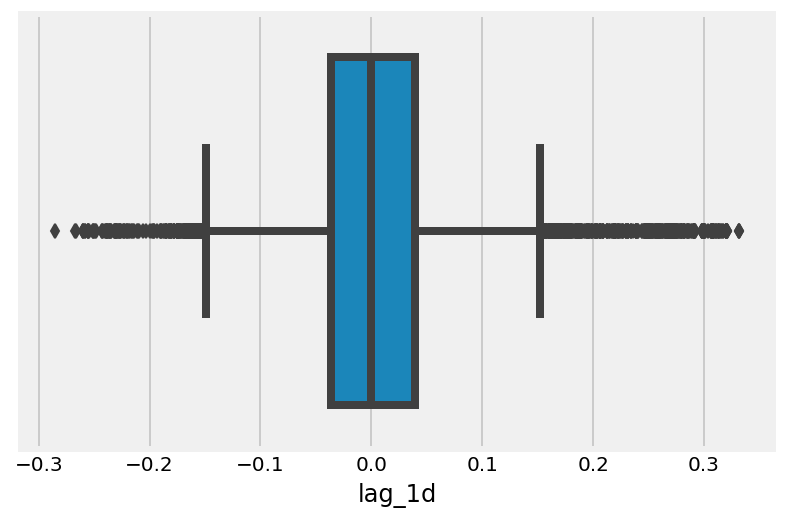

In [76]:
sns.boxplot(train_response["lag_1d"])

In [77]:
colnames = {"lag_1m":60,"lag_5m":300,"lag_10m":600,"lag_30m":1800,"lag_60m":3600,"lag_12h":43200,"lag_1d":86400,
           "lag_2d":172800,"lag_4d": 345600}

### 3.2 Mean Difference in Price Change for different Sentiment 

First, we look at the mean price change for different sentiment. 

In [78]:
articles.head(1)

,Unnamed: 0,index,author,contents,description,publisher,source_url,title,date,time,...,predicted_sentiment,lag_1m,lag_5m,lag_10m,lag_30m,lag_60m,lag_12h,lag_1d,lag_2d,lag_4d
timeStamp,,,,,,,,,,,,,,,,,,,,,
2018-01-23,0,0,Stripe.com,complete payments platform engineered growth b...,"At Stripe, we’ve long been excited about the p...",Stripe.com,https://stripe.com/blog/ending-bitcoin-support,Ending Bitcoin Support,2018-01-23,00:00:00,...,1.0,-0.000255,-0.004628,0.003677,-0.006573,9.259276e-07,-0.066983,0.008283,0.048753,0.026566


In [79]:
round(np.mean(articles.lag_30m)*100,4)

0.0022

In [80]:
round(np.mean(articles.lag_30m.loc[articles.predicted_sentiment==0.0])*100,4)

-0.0174

In [81]:
round(np.mean(articles.lag_30m.loc[articles.predicted_sentiment==1.0])*100,4)

-0.0071

In [82]:
round(np.mean(articles.lag_30m.loc[articles.predicted_sentiment==-1.0])*100,4)

0.0274

In [83]:
round(np.mean(articles.lag_30m.loc[articles.marks==0.0])*100,4)

-0.0109

In [84]:
round(np.mean(articles.lag_30m.loc[articles.marks==1.0])*100,4)

0.0072

There seems to be a difference in mean price changes for different sentiment. 

### 3.3 Evaluate difference in price changes using linear regression 

Since we see that the mean price change is different for different sentiment, we use a logistic regression model to find out whether it is significant. 

In [85]:
import statsmodels.api as sm

for j in colnames:
    
    lm = sm.OLS(articles[j],sm.add_constant(articles.predicted_sentiment)).fit()
    
    print("OLS for ",j)
    print(lm.summary())
    print("")
    print("")

OLS for  lag_1m
                            OLS Regression Results                            
Dep. Variable:                 lag_1m   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2594
Date:                Thu, 06 Dec 2018   Prob (F-statistic):              0.611
Time:                        15:55:36   Log-Likelihood:             1.9797e+05
No. Observations:               40732   AIC:                        -3.959e+05
Df Residuals:                   40730   BIC:                        -3.959e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const             

We see that the higher we go in our time lag, the more the signficance of the coefficients in our regression increases. However, although there is a signficicant relationship between sentiment and price, the R-squared is pretty low, indicating that sentiment actually does not carry a lot of predictive capacity. We therefore decided to train our final model, which is trying to predict prices, with both sentiment and vectorized article data. 

In [86]:
import statsmodels.api as sm

for j in colnames:
    
    lm = sm.OLS(articles[j],sm.add_constant(articles.marks)).fit()
    
    print("OLS for ",j)
    print(lm.summary())
    print("")
    print("")




OLS for  lag_1m
                            OLS Regression Results                            
Dep. Variable:                 lag_1m   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5884
Date:                Thu, 06 Dec 2018   Prob (F-statistic):              0.443
Time:                        15:55:36   Log-Likelihood:             1.9797e+05
No. Observations:               40732   AIC:                        -3.959e+05
Df Residuals:                   40730   BIC:                        -3.959e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.335e-05   1.77e-05    

This relationship also holds true for the labeled data using unsupervised learning (past semester's method). 

## 4. Article Scoring

We use both sentiment and vectorized article text as features to predict prices. Those prediction will be then tranformed into a scoring which represents the signficance of a given article on Bitcoin price change. We do this for daily Bitcoin data based on the insights we got from the EDA and the last section in this notebook, saying that the higher we go in time, the stronger the influence of news data on price. 

### 4.1 nlp features 

In [87]:
nlp = nlp_validation_sets(fold = train,validation = test,train_data = articles,max_features=100,method_nlp = "stem",ngram = 1)

In [88]:
nlp.choose_w2v(method = "count")

In [89]:
nlp.fit()

time elapsed 16.5


In [90]:
X = nlp.transform_train()

In [91]:
X_test = nlp.transform_test()

In [92]:
X.shape

(30549, 100)

In [93]:
X_test.shape

(10183, 100)

### 4.2 train models and evaluate models 

In [94]:
train_response.shape

(30549, 9)

In [95]:
X.shape

(30549, 100)

In [96]:
X_test.shape

(10183, 100)

In [97]:
test_response.shape

(10183, 9)

### 4.3 benchmark: naive (use last price change as predictor for current price change)

We use a naive model as a benchmark. Naive means that price change = price change (t-1), so the predicted price change is simply the last price change. We do this for different time lags. 

In [98]:
from sklearn.metrics import mean_squared_error
colnames = {"lag_1m":60,"lag_5m":300,"lag_10m":600,"lag_30m":1800,"lag_60m":3600,"lag_12h":43200,"lag_1d":86400,
           "lag_2d":172800,"lag_4d": 345600}

for j in colnames:
    print("benchmark training error:",j,":",round(mean_squared_error(train_response[j],train_naive[j]),5))


benchmark training error: lag_1m : 1e-05
benchmark training error: lag_5m : 3e-05
benchmark training error: lag_10m : 7e-05
benchmark training error: lag_30m : 0.0002
benchmark training error: lag_60m : 0.00041
benchmark training error: lag_12h : 0.00396
benchmark training error: lag_1d : 0.00889
benchmark training error: lag_2d : 0.01603
benchmark training error: lag_4d : 0.02818


In [99]:
for j in colnames:
    print("benchmark testing error:",j,":",round(mean_squared_error(test_response[j],test_naive[j]),5))

benchmark testing error: lag_1m : 1e-05
benchmark testing error: lag_5m : 3e-05
benchmark testing error: lag_10m : 6e-05
benchmark testing error: lag_30m : 0.00019
benchmark testing error: lag_60m : 0.0004
benchmark testing error: lag_12h : 0.00397
benchmark testing error: lag_1d : 0.00893
benchmark testing error: lag_2d : 0.01604
benchmark testing error: lag_4d : 0.02795


### 4.4 benchmark: AR-1 linear regresion (regress on past price change)

We then compare a autoregressive linear regression as a benchmark. 
We compute the test error of the linear regression as a fraction of the test error of our naive benchmark. 
Our models should at least beat the AR-1 linear regression. 

In [100]:
from sklearn.linear_model import LinearRegression
for j in colnames:
    reg = LinearRegression()
    reg.fit(train_naive,train_response[j])
    #pred = reg.predict(train_naive)
    #print("linear regression training error:",j,round(mean_squared_error(pred,train_response[j])/
                                                      #mean_squared_error(train_response[j],train_naive[j]),5))
    pred = reg.predict(test_naive)
    #print("")
    print("AR-1 linear regression test error:",j,round(mean_squared_error(pred,test_response[j])/
                                                  mean_squared_error(test_response[j],test_naive[j]),5))

AR-1 linear regression test error: lag_1m 0.52073
AR-1 linear regression test error: lag_5m 0.52643
AR-1 linear regression test error: lag_10m 0.49202
AR-1 linear regression test error: lag_30m 0.49134
AR-1 linear regression test error: lag_60m 0.46501
AR-1 linear regression test error: lag_12h 0.47748
AR-1 linear regression test error: lag_1d 0.42965
AR-1 linear regression test error: lag_2d 0.4483
AR-1 linear regression test error: lag_4d 0.56196


### 4.5 linear regression / lasso regression with NLP features

Before we dive into more complex models, we fit a linear and lasso regression. We do this for all time lags. 

In [101]:
X = np.concatenate((X.toarray(),train[["predicted_sentiment","rnn sentiment"]].values),axis = 1)

In [102]:
X.shape

(30549, 102)

In [103]:
X_test = np.concatenate((X_test.toarray(),test[["predicted_sentiment","rnn sentiment"]].values),axis = 1)

In [104]:
X_test.shape

(10183, 102)

In [105]:
test_response.shape

(10183, 9)

In [106]:
# linear regression: train 
for j in colnames:
    reg = LinearRegression()
    reg.fit(X,train_response[j])

    pred = reg.predict(X_test)
    #print("")
    print("linear regression test error:",j,round(mean_squared_error(pred,test_response[j])/
                                                  mean_squared_error(test_response[j],test_naive[j]),5))

linear regression test error: lag_1m 0.52092
linear regression test error: lag_5m 0.52712
linear regression test error: lag_10m 0.49376
linear regression test error: lag_30m 0.49027
linear regression test error: lag_60m 0.46505
linear regression test error: lag_12h 0.48629
linear regression test error: lag_1d 0.43392
linear regression test error: lag_2d 0.44389
linear regression test error: lag_4d 0.55156


### 4.6 lasso regression with NLP features (with 5-fold cross validation)

In [107]:
#from: https://www.kaggle.com/floser/aw6-the-lasso-cross-validated
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
from sklearn.preprocessing import scale
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
#from sklearn import cross_validation

for j in colnames:
    alphas = [1,5,10,50,100,1000]
    lassocv = LassoCV(alphas=alphas, cv=5, max_iter=100000, normalize=True)
    lassocv.fit(X, train_response[j])
    lasso = Lasso()
    lasso.set_params(alpha=lassocv.alpha_)
    #print("Alpha=", lassocv.alpha_)
    lasso.fit(X, train_response[j])
    #print("mse = ",mean_squared_error(y_test, lasso.predict(X_test)))
    #print("best model coefficients:")
    #pd.Series(lasso.coef_, index=X.columns)
    #pred = lasso.predict(X)
    #print("lasso regression training error:",j,round(mean_squared_error(pred,train_response[j])/
                                                      #mean_squared_error(train_response[j],train_naive[j]),5))
    
    pred = lasso.predict(X_test)
    print("lasso R squared:",j,lasso.score(X,train_response[j]))
    print("lasso regression test error:",j,round(mean_squared_error(pred,test_response[j])/
                                                  mean_squared_error(test_response[j],test_naive[j]),5))
    

lasso R squared: lag_1m 0.0
lasso regression test error: lag_1m 0.52028
lasso R squared: lag_5m 0.0
lasso regression test error: lag_5m 0.52693
lasso R squared: lag_10m 0.0
lasso regression test error: lag_10m 0.49379
lasso R squared: lag_30m 0.0
lasso regression test error: lag_30m 0.49205
lasso R squared: lag_60m 0.0
lasso regression test error: lag_60m 0.46784
lasso R squared: lag_12h 0.0
lasso regression test error: lag_12h 0.49192
lasso R squared: lag_1d 0.0
lasso regression test error: lag_1d 0.44055
lasso R squared: lag_2d 0.0
lasso regression test error: lag_2d 0.45166
lasso R squared: lag_4d 0.0
lasso regression test error: lag_4d 0.56981


Both linear and lasso regression do not perform better than a simple AR-1 model. Therefore, we will explore more complex models. 

### 4.7 random forest regressor with NLP features

In [108]:
#from: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

#from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

start = time.time()

colnames = {"lag_1m":60,"lag_5m":300,"lag_10m":600,"lag_30m":1800,"lag_60m":3600,"lag_12h":43200,"lag_1d":86400,
           "lag_2d":172800,"lag_4d": 345600}

model = ["lag_1d"]

for j in model:
    
    
    rf = RandomForestRegressor()
    
    n_estimators = [500]
    max_features = [.3,0.6]
    max_depth = [None]

    param_grid = {'n_estimators': n_estimators,'max_features': max_features,"max_depth":max_depth}
    
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 2,scoring = "neg_mean_squared_error")

    #rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 4, 
                               #cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the grid search model
    grid_search.fit(X, train_response[j])

    best_param = grid_search.best_params_

    rf_d = RandomForestRegressor(n_estimators = best_param["n_estimators"],max_features = best_param["max_features"]
                             ,max_depth = best_param["max_depth"])
    rf_d.fit(X,train_response[j])

    pred = rf_d.predict(X_test)
    pred_rf = rf_d.predict(X_test)

    print("random forest test error:",j,round(mean_squared_error(pred,test_response[j])/
                                                  mean_squared_error(test_response[j],test_naive[j]),5))
   
print("time elapsed:",round((time.time()-start)/60,1),"minutes")

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.0min finished


random forest test error: lag_1d 0.15027
time elapsed: 7.9 minutes


The random forest model performs significantly better than a simple AR-1 model for daily data. It seems that we found a model which is able to extract signal from data. 

In [109]:
best_param

{'max_depth': None, 'max_features': 0.3, 'n_estimators': 500}

Text(0,0.5,'Actual Daily Price Change')

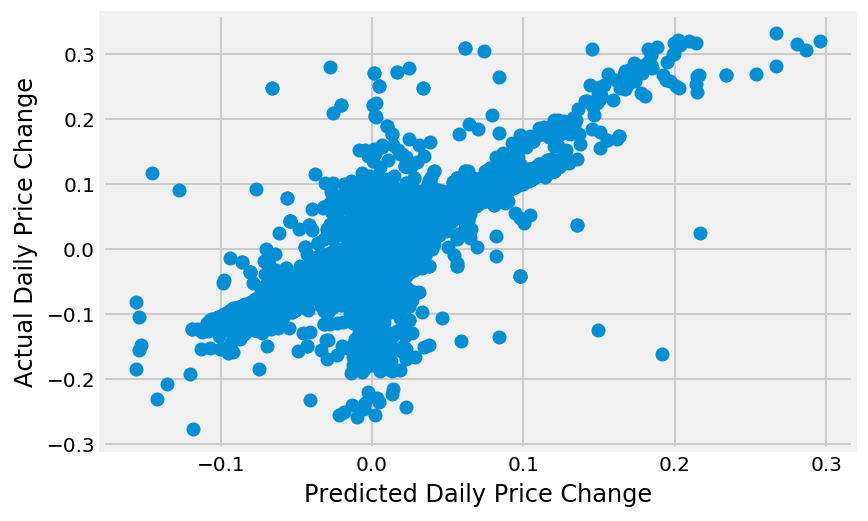

In [110]:
import matplotlib.pyplot as plt
plt.plot(pred_rf,test_response["lag_1d"],"o")
plt.xlabel('Predicted Daily Price Change')
plt.ylabel('Actual Daily Price Change')

This can be confirmed by a plot showing predicted and actual values of our random forest model. 

### 4.8 gbm with cv 

Let's try a second "complex" model. 

In [111]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

start = time.time()

colnames = {"lag_1m":60,"lag_5m":300,"lag_10m":600,"lag_30m":1800,"lag_60m":3600,"lag_12h":43200,"lag_1d":86400,
           "lag_2d":172800,"lag_4d": 345600}

model = ["lag_1d"]

for j in model:
    
    
    #a = np.concatenate((train_dummies,np.array(train_naive[j]).reshape(len(train_naive[j]),1),X),axis = 1)
    #b = np.concatenate((test_dummies,np.array(test_naive[j]).reshape(len(test_naive[j]),1),X_test),axis = 1)
    
    gbm = GradientBoostingRegressor()
    
    max_features = [0.8]
    subsample = [.7]
    max_depth = [1,3,6]
    learning_rate = [.1]
    n_estimators=[100,200]

    param_grid = {'max_features': max_features,"max_depth":max_depth,
                 "subsample":subsample,"learning_rate":learning_rate,"n_estimators":n_estimators}
    
    grid_search = GridSearchCV(estimator = gbm, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 2,scoring = "neg_mean_squared_error")

    #rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 4, 
                               #cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the grid search model
    grid_search.fit(X, train_response[j])

    best_param = grid_search.best_params_

    gbm_d = GradientBoostingRegressor(max_features = best_param["max_features"],max_depth = best_param["max_depth"],
                                      subsample = best_param["subsample"],learning_rate = best_param["learning_rate"],
                                    n_estimators = best_param["n_estimators"]
                                    )
    gbm_d.fit(X,train_response[j])

    pred = gbm_d.predict(X_test)
    pred_gbm = gbm_d.predict(X_test)

    print("gbm test error:",j,round(mean_squared_error(pred,test_response[j])/
                                                  mean_squared_error(test_response[j],test_naive[j]),5))
    
print("time elapsed:",round((time.time()-start)/60,1),"minutes")

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.5min finished


gbm test error: lag_1d 0.27967
time elapsed: 3.9 minutes


Gradient boosting performs better than a AR-1 model and similar to random forest.

In [112]:
best_param

{'learning_rate': 0.1,
 'max_depth': 6,
 'max_features': 0.8,
 'n_estimators': 200,
 'subsample': 0.7}

In [113]:
gbm_d.n_estimators

200

In [114]:
#grid_search.cv_results_

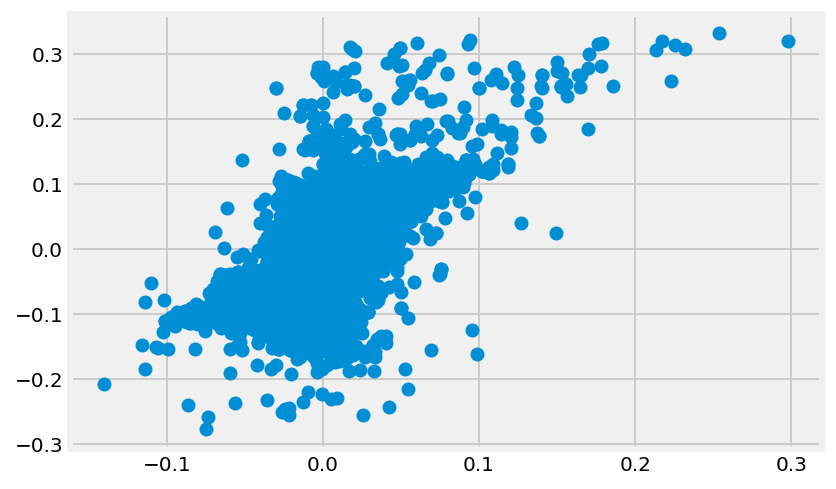

In [115]:
import matplotlib.pyplot as plt
plt.plot(pred,test_response["lag_1d"],"o")

### 4.9 Final Scoring 

We take the predicitons from the random forest model to create our final scoring. For the final scoring, we will use min-max scaling of the absolute predicted price change of the random forest model. 

In [116]:
pred_rf

array([-0.0546572 , -0.01654444, -0.02632338, ...,  0.00125568,
       -0.01768976,  0.12457519])

In [117]:
def create_score(prediction):
    min_ = np.percentile(abs(prediction),2)
    max_ = np.percentile(abs(prediction),98)
    
    new_list = []
    
    for i in abs(prediction):
        if i < min_:
            new_list.append(10)
        elif i>max_:
            new_list.append(10)
        else:
            new_list.append(round((i-min_)/(max_-min_)*10))
    return new_list

In [118]:
scoring = create_score(pred_rf)

In [119]:
min(scoring)

0.0

In [120]:
max(scoring)

10

## 5. Evaluation

We are doing a quick evaluation of our scoring by looking at the predicted score, the actual and predicted price change and the title of the article, taking a random sample from our predictions. 

Text(0,0.5,'Actual Daily Price Change')

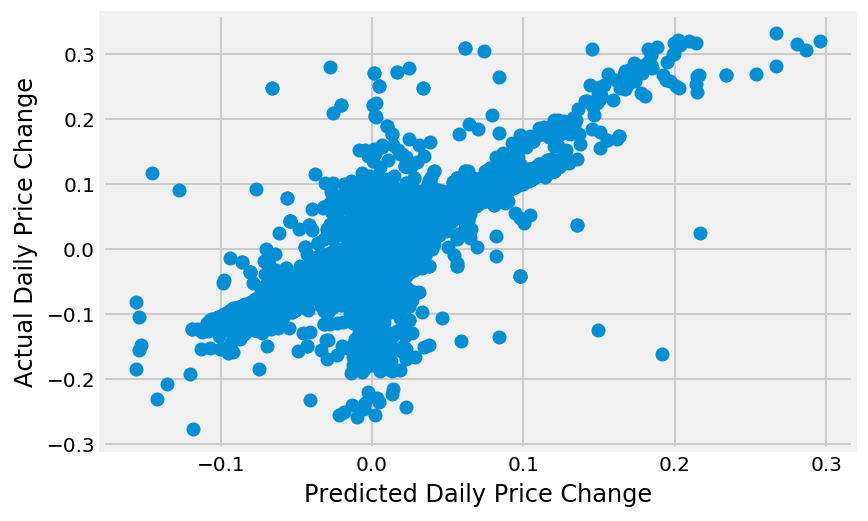

In [121]:
import matplotlib.pyplot as plt
plt.plot(pred_rf,test_response["lag_1d"],"o")
plt.xlabel('Predicted Daily Price Change')
plt.ylabel('Actual Daily Price Change')

In [122]:
df = pd.DataFrame(scoring,columns = ["scoring"])

In [123]:
df["abs_true_value"]=abs(test["lag_1d"].values)

In [124]:
df.head()

,scoring,abs_true_value
0,5.0,0.056587
1,1.0,0.018110
2,2.0,0.036806
3,6.0,0.066091
4,3.0,0.036708


In [125]:
df = round(df.groupby(["scoring"]).agg(['mean', 'count']),2)

In [126]:
df["rel_frequency"]=df.iloc[:,1].values/len(test)
df["rel_frequency"] = round(df["rel_frequency"],2)

In [127]:
df

abs_true_value       rel_frequency
                  mean count              
scoring                                   
0.0               0.03  1594          0.16
1.0               0.03  2123          0.21
2.0               0.03  1428          0.14
3.0               0.04  1423          0.14
4.0               0.05  1023          0.10
5.0               0.06   756          0.07
6.0               0.07   657          0.06
7.0               0.09   284          0.03
8.0               0.10   263          0.03
9.0               0.11   171          0.02
10.0              0.11   461          0.05

In [128]:
import random
rand = []
for x in range(10):
    rand.append(random.randint(0,len(pred_rf)))

for i in rand:
    print("true value:",round(test_response["lag_4d"].iloc[i],2),"","predicted value:",round(pred_rf[i],2),"",
         "predicted scoring:",scoring[i])
    print("")
    print("Article Title:",test["title"].iloc[i])
    print("")
    print("")

true value: -0.09  predicted value: -0.04  predicted scoring: 4.0

Article Title: Uganda’s bitcoin enthusiasts


true value: 0.12  predicted value: 0.09  predicted scoring: 9.0

Article Title: ICOs and Token Rights: The Need for Governance


true value: 0.07  predicted value: 0.01  predicted scoring: 1.0

Article Title: EU says stands ready to regulate cryptocurrencies


true value: 0.05  predicted value: 0.0  predicted scoring: 0.0

Article Title: Vanguard's Joe Davis Says Bitcoin Will Go to Zero


true value: 0.03  predicted value: 0.01  predicted scoring: 1.0

Article Title: Scammers Are Stealing Bitcoin on Twitter With a Classic Scheme


true value: 0.1  predicted value: -0.01  predicted scoring: 1.0

Article Title: Coinbase Launches Cryptocurrency Payment Platform for Businesses


true value: -0.02  predicted value: -0.01  predicted scoring: 1.0

Article Title: Fintech and Blockchain Mavens Launch International Digital Asset Exchange Council ('IDAXC') to Accelerate the Mainstreami

## 6. Appendix